In [0]:
from google.colab import drive
import os
drive.mount('/content/drive/')
path_basic = 'drive/My Drive/gan_experiments'
os.chdir(path_basic)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import torch
from torch.nn import init
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter 

from skimage.filters import threshold_otsu
import cv2
from PIL import Image
import functools
import itertools
import numpy as np
import random

import os
import sys
import glob
from tqdm import tqdm_notebook
import re

import matplotlib.pyplot as plt
import pickle
import time

### Model

In [0]:
class SENet(nn.Module):
  def __init__(self, input_nc, r=16):
    super(SENet, self).__init__()
    self.input_nc = input_nc
    self.fc1 = nn.utils.spectral_norm(nn.Linear(input_nc, int(input_nc / r)))
    self.relu = nn.ReLU()
    self.fc2 = nn.utils.spectral_norm(nn.Linear(int(input_nc / r), input_nc))
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    input_dim = x.shape[2]
    gap = F.avg_pool2d(x, input_dim)
    gap = gap.view(gap.shape[0], -1)

    h = self.fc1(gap)
    h = self.relu(h)
    h = self.fc2(h)
    attn = self.sigmoid(h)

    output = x * attn.unsqueeze(2).unsqueeze(3)
    return output

class ResidualBlock(nn.Module):
    """
      SEDResidualBlock
      Parameters:
        dilation_factor -- dilated convolution hyperparam
        r -- reduction factor for SE bottleneck
    """
    def __init__(self, in_features, dilation_factor, r=4):
        super(ResidualBlock, self).__init__()
        k = 3
        d = dilation_factor
        pad = int(((k - 1) * (d - 1) + k - 1) / 2)

        conv_block = [  nn.ReflectionPad2d(pad),
                        nn.utils.spectral_norm(nn.Conv2d(in_features, in_features, 3, dilation=d)),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                      
                        nn.ReflectionPad2d(pad),
                        nn.utils.spectral_norm(nn.Conv2d(in_features, in_features, 3, dilation=d)),
                        nn.InstanceNorm2d(in_features),
                        SENet(in_features, r=r)
                      ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)


class Generator_S2F(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9,
                 dilation_factors=[1,1,2,4,8,16,2,1,1],
                 reduction=4):
        super(Generator_S2F, self).__init__()
        assert len(dilation_factors) == n_residual_blocks

        # Initial convolution block
        model = [   nn.ReflectionPad2d(3),
                    nn.utils.spectral_norm(nn.Conv2d(input_nc, 64, 7)),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.utils.spectral_norm(nn.Conv2d(in_features, out_features, 3, stride=2, padding=1)),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for i in range(n_residual_blocks):
          d = dilation_factors[i]
          model += [ResidualBlock(in_features,dilation_factor=d,r=reduction)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.utils.spectral_norm(nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1)),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.utils.spectral_norm(nn.Conv2d(64, output_nc, 7)) ]
                    #nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return (self.model(x) + x).tanh() #(min=-1, max=1) #just learn a residual

### Variables definition

In [0]:
class ImageDataset(Dataset):
    def __init__(self, root, paired=False, transforms_=None, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.paired = paired
        self.files_A = sorted(glob.glob(os.path.join(root, f'{mode}/{mode}_A', '*.*')))
        self.files_B = sorted(glob.glob(os.path.join(root, f'{mode}/{mode}_C', '*.*')))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        if self.paired:
          item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))
          return {'A': item_A, 'B': item_B}  
        item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [0]:
root_dir = 'data/ISTD_Dataset/'
checkpoint_dir_011 = 'mask_shadow_gan/output/checkpoints/checkpoints_v0.1.1/1/'
checkpoint_dir_010 = 'mask_shadow_gan/output/checkpoints/checkpoints_v0.1.0/2/'

image_size=256

In [0]:
test_transforms = [
      transforms.Resize((image_size, image_size), interpolation=Image.BICUBIC),
      transforms.ToTensor(),
      transforms.Normalize((.5,.5,.5),(.5,.5,.5))
]

In [0]:
dataset = ImageDataset(root_dir, paired=True, transforms_=test_transforms)
batch = dataset[1]

In [0]:
img_A = batch['A']
img_B = batch['B']

In [0]:
img_A_conv = (img_A + 1) * 127.5

In [0]:
img_A = img_A.permute(1,2,0).numpy()
img_A_conv = img_A_conv.permute(1,2,0).numpy()

In [0]:
from skimage import color, io

In [0]:
class Evaluator(object):
  def __init__(self, directory, transforms_, checkpoint_dir, mode='test'):
    paired = True if mode == 'test' else False
    self.dataset = DataLoader(ImageDataset(directory, paired=paired, transforms_=transforms_, mode=mode), 
                          batch_size=1, shuffle=False, num_workers=os.cpu_count())
    self.checkpoint_dir = checkpoint_dir
    self.cuda = torch.cuda.is_available()
    self.device = torch.device('cuda') if self.cuda else torch.device('cpu')
    self.Tensor = torch.cuda.FloatTensor if self.cuda else torch.FloatTensor


  def evaluate(self):
    input_A = self.Tensor(1, 3, image_size, image_size)
    input_B = self.Tensor(1, 3, image_size, image_size)

    # load latest checkpoint of the model
    print("------ Load the model ----- ")
    netG_A2B = Generator_S2F(3, 3).to(self.device)
    netG_A2B.load_state_dict(torch.load(os.path.join(self.checkpoint_dir, 'netG_A2B.pth')))
    netG_A2B.eval()

    scores = []
    for i, batch in tqdm_notebook(enumerate(self.dataset), total=len(self.dataset)):
      real_A = Variable(input_A.copy_(batch['A']))
      real_B = Variable(input_B.copy_(batch['B']))

      pred_B = netG_A2B(real_A)
      score = self._evaluate(real_B, pred_B)
      scores.append(score)
    
    scores = np.asarray(scores)
    print(f'Mean rmse: {np.mean(scores)}')
    return scores


  def _evaluate(self, image_true, image_pred):
    image_true = self._convert_image_array(image_true)
    image_pred = self._convert_image_array(image_pred)

    # image_true = cv2.cvtColor(image_true, cv2.COLOR_RGB2LAB)
    # image_pred = cv2.cvtColor(image_pred, cv2.COLOR_RGB2LAB)
    image_true = color.rgb2lab(image_true)
    image_pred = color.rgb2lab(image_pred)

    rmse = np.sqrt(np.square(image_true - image_pred))
    return np.mean(rmse)


  def _convert_image_array(self, image):
    image = 127.5 * (image.squeeze(0) + 1)
    image = image.permute(1,2,0)
    if not self.cuda:
      image = image.numpy().astype(np.uint8)
      return image
    
    return image.data.cpu().numpy().astype(np.uint8)

In [0]:
evaluator_011 = Evaluator(root_dir, transforms_=test_transforms, 
                      checkpoint_dir=checkpoint_dir_011, mode='test')

In [0]:
scores_011 = evaluator_011.evaluate()

------ Load the model ----- 



Mean rmse: 23.002874545575512


In [0]:
plt.subplots(figsize=(20,10))
plt.plot(scores, label=f"Mean: {scores.mean():.3f}")
plt.legend();

NameError: ignored

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator_S2F(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator_S2F, self).__init__()

        # Initial convolution block
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7) ]
                    #nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return (self.model(x) + x).tanh() #(min=-1, max=1) #just learn a residual

In [0]:
evaluator_010 = Evaluator(root_dir, transforms_=test_transforms, 
                      checkpoint_dir=checkpoint_dir_010, mode='test')
scores_010 = evaluator_010.evaluate()

------ Load the model ----- 



Mean rmse: 2.3711865554047797


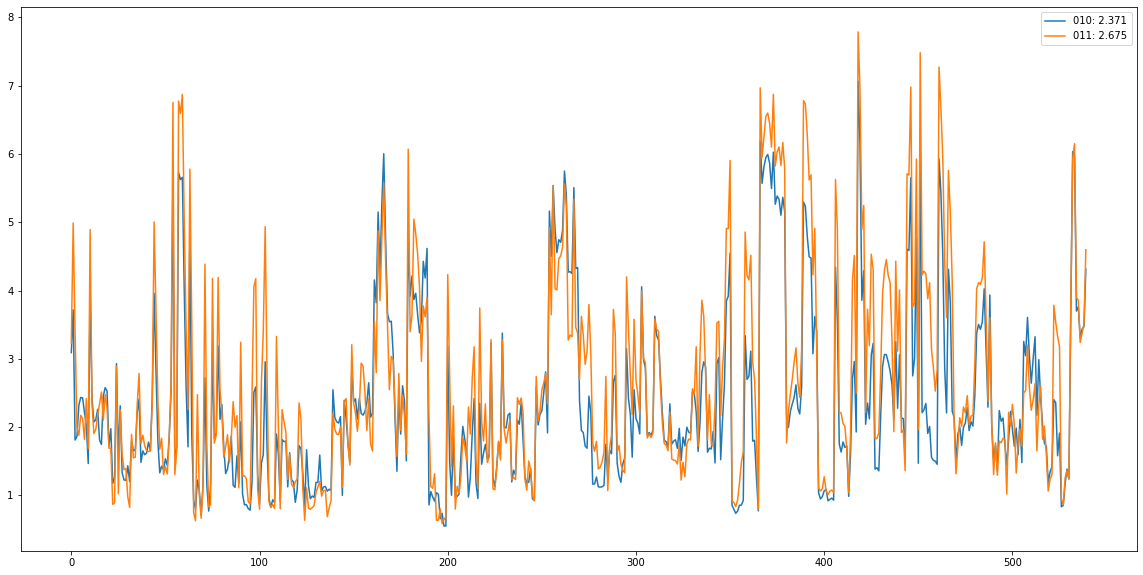

In [0]:
plt.subplots(figsize=(20,10))
plt.plot(scores_010, label=f"010: {scores_010.mean():.3f}")
plt.plot(scores_011, label=f"011: {scores_011.mean():.3f}")
plt.legend();

In [0]:
np.mean(scores_011) / np.mean(scores_010) % 1

0.1281810751107555

In [0]:
dataset = ImageDataset(root_dir, paired=True, transforms_=test_transforms)
batch = dataset[1]

In [0]:
input_A = torch.cuda.FloatTensor(1, 3, image_size, image_size)
input_B = torch.cuda.FloatTensor(1, 3, image_size, image_size)
device = torch.device('cuda')

netG_A2B = Generator_S2F(3, 3).to(device)
netG_A2B.load_state_dict(torch.load(os.path.join(checkpoint_dir_011, 'netG_A2B.pth')))
netG_A2B.eval()

scores = []
real_A = Variable(input_A.copy_(batch['A']))
real_B = Variable(input_B.copy_(batch['B']))

pred_B = netG_A2B(real_A)

In [0]:
pred_B_conv = evaluator._convert_image_array(pred_B)
real_B_conv = evaluator._convert_image_array(real_B)

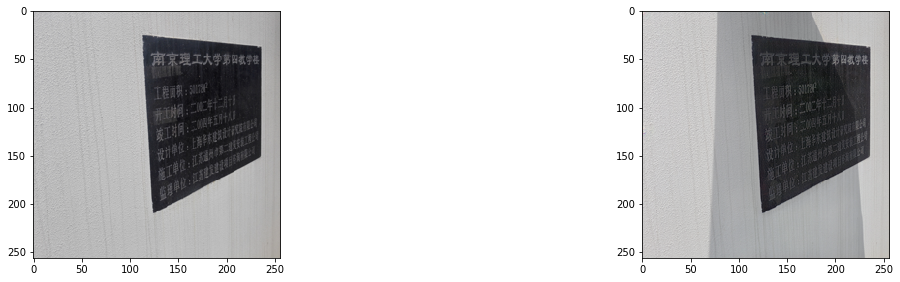

In [0]:
plt.subplots(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(real_B_conv)

plt.subplot(2,2,2)
plt.imshow(pred_B_conv)

In [0]:
def evaluate(evalt, image_true, image_pred):
  image_true = evalt._convert_image_array(image_true)
  image_pred = evalt._convert_image_array(image_pred)

  image_true = cv2.cvtColor(image_true, cv2.COLOR_RGB2LAB)
  image_pred = cv2.cvtColor(image_pred, cv2.COLOR_RGB2LAB)

  rmse = np.sqrt(np.square(image_true - image_pred))
  return rmse

In [0]:
error = evaluate(evaluator, real_B, pred_B)

In [0]:
error.flatten()

array([ 4.  ,  2.  , 12.  , ..., 10.63,  1.  ,  1.  ], dtype=float16)

In [0]:
np.sum(error.flatten())

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


inf

In [0]:
error.flatten().shape

(196608,)

In [0]:
error.max()

15.78

(array([114168.,  20435.,   5746.,   5036.,   1579.,   8648.,  11193.,
          9019.,  13788.,   6996.]),
 array([ 0.   ,  1.578,  3.156,  4.734,  6.312,  7.89 ,  9.47 , 11.05 ,
        12.625, 14.2  , 15.78 ], dtype=float16),
 <a list of 10 Patch objects>)

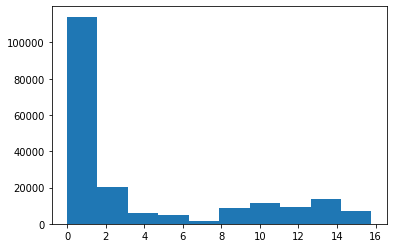

In [0]:
plt.hist(error.flatten())